## Missing Fingers

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
import tqdm

import probability_on_trial as pot
from probability_on_trial.weight import weight as weight

## Core model

This is the model that given **precise** values of the parameters, estimates the posterior for two cases: (i) we know the person is from Sweden, (ii) we also know that they were in ISIS.

In [2]:
pyro.set_rng_seed(42)


pr_identity = (
    1 / 50
)  # high prior at this point, given other circumstantial information (tip from a woman, travel pattern, etc)
rmp_fingers_sweden = 2 / 20000  # RMP for Sweden
pr_fingers_match_if_isis = 2 / 2000  # RMP for ISIS memebers; for now a precise number


def swedish_fingers_guilt_precise_core(
    pr_identity: float = pr_identity,
    rmp_fingers_sweden: float = rmp_fingers_sweden,
    pr_fingers_match_if_isis: float = pr_fingers_match_if_isis,
    num_particles=3e6,
):

    with pyro.plate("particles", size=num_particles):

        guilty = pyro.sample("guilty", dist.Bernoulli(pr_identity))

        fingers_match_sweden = pyro.sample(
            "fingers_match_sweden",
            # if guilty then 1
            # if not guilty then sample with probability rmp
            dist.Bernoulli(guilty * 1 + (1 - guilty) * (rmp_fingers_sweden)),
        )

        fingers_match_isis = pyro.sample(
            "fingers_match_isis",
            dist.Bernoulli(guilty * 1 + (1 - guilty) * pr_fingers_match_if_isis),
        )

    # Evidence mask 1: fingers match
    evidence_mask_fingers_sweden = (fingers_match_sweden).bool()
    guilty_masked_fingers_sweden = pyro.deterministic(
        "guilty_masked_fingers_sweden",
        torch.where(evidence_mask_fingers_sweden, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_sweden = pyro.deterministic(
        "posterior_guilty_fingers_sweden",
        torch.nanmean(guilty_masked_fingers_sweden, axis=0),
    )

    # Mask 2: fingers match, isis
    evidence_mask_fingers_isis = (fingers_match_isis).bool()

    guilty_masked_fingers_isis = pyro.deterministic(
        "guilty_masked_fingers_isis",
        torch.where(evidence_mask_fingers_isis, guilty, torch.tensor(float("nan"))),
    )

    posterior_guilty_fingers_isis = pyro.deterministic(
        "posterior_guilty_fingers_isis",
        torch.nanmean(guilty_masked_fingers_isis, axis=0),
    )

    return {
        "posterior_guilty_fingers_sweden": posterior_guilty_fingers_sweden,
        "posterior_guilty_fingers_isis": posterior_guilty_fingers_isis,
    }


pyro.set_rng_seed(422323)
outcome = swedish_fingers_guilt_precise_core()
print(outcome)

posterior_sweden = outcome["posterior_guilty_fingers_sweden"]
posterior_isis = outcome["posterior_guilty_fingers_isis"]

{'posterior_guilty_fingers_sweden': tensor(0.9949), 'posterior_guilty_fingers_isis': tensor(0.9540)}


## Grid inspection

Here we look at a range of options and inspect the impact they'd have on the posteriors.

In [3]:
prior_options = torch.linspace(0.001, 0.1, 30)
isis_options = torch.linspace(1, 20, 30) * 2 / 20000

prior_grid, isis_grid = torch.meshgrid(prior_options, isis_options)

prior_flat = prior_grid.flatten()
isis_flat = isis_grid.flatten()

sweden_list = []
isis_list = []

iter = tqdm.notebook.tqdm(range(len(isis_flat)), desc="Combination")
for i in iter:
    pr = prior_flat[i]
    isis = isis_flat[i]

    outcome = swedish_fingers_guilt_precise_core(
        pr_identity=pr, pr_fingers_match_if_isis=isis
    )
    sweden_list.append(outcome["posterior_guilty_fingers_sweden"])
    isis_list.append(outcome["posterior_guilty_fingers_isis"])

/home/rafal/.local/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Combination:   0%|          | 0/900 [00:00<?, ?it/s]

bone


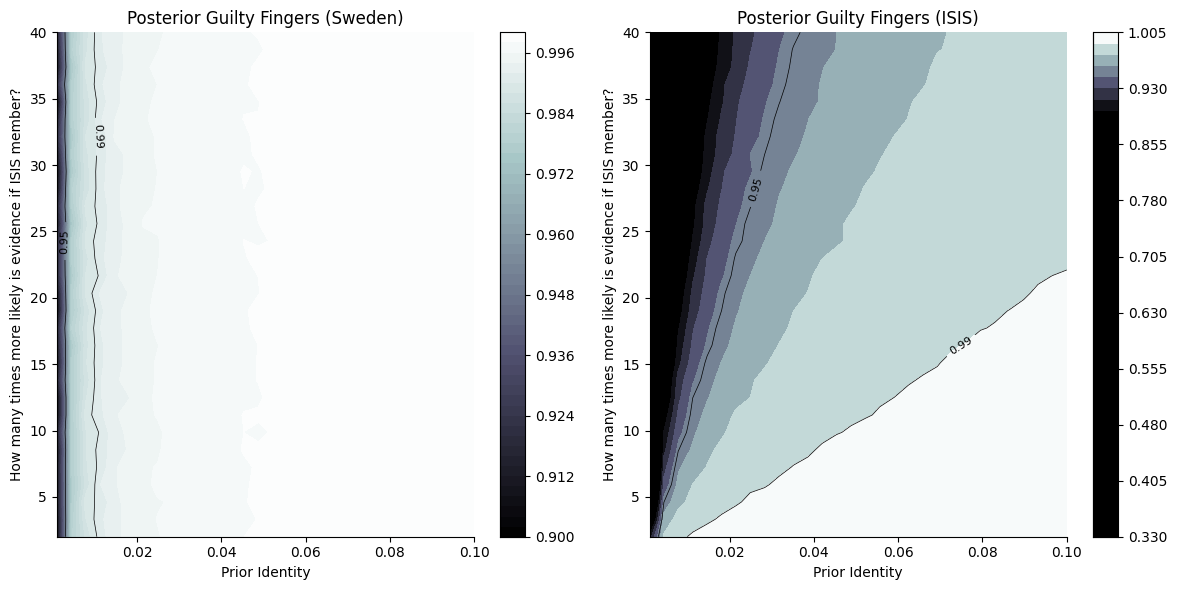

In [4]:
Norm = plt.Normalize(vmin=0.9, vmax=1)

grid_shape = (len(prior_options), len(isis_options))
sweden_array = np.clip(np.array(sweden_list).reshape(grid_shape), a_min=0, a_max=1)
isis_array = np.clip(np.array(isis_list).reshape(grid_shape), a_min=0, a_max=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

colormaps = plt.colormaps()

cmap = colormaps[40]

print(cmap)

c1 = ax[0].contourf(
    prior_options.numpy(),
    isis_options.numpy(),
    sweden_array.T,
    levels=50,
    cmap=cmap,
    norm=Norm,
)
clines1 = ax[0].contour(
    prior_options.numpy(),
    isis_options.numpy(),
    sweden_array.T,
    levels=[0.95, 0.99],
    colors="k",
    linewidths=0.5,
)
ax[0].clabel(clines1, inline=True, fontsize=8, fmt="%.2f")
ax[0].set_title("Posterior Guilty Fingers (Sweden)")
ax[0].set_xlabel("Prior Identity")
formatter = ticker.FuncFormatter(lambda x, _: f"{x * 20000:,.0f}")
ax[0].yaxis.set_major_formatter(formatter)
ax[0].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c1, ax=ax[0])

# Plot for ISIS
c2 = ax[1].contourf(
    prior_options.numpy(),
    isis_options.numpy(),
    isis_array.T,
    levels=50,
    cmap=cmap,
    norm=Norm,
)
clines2 = ax[1].contour(
    prior_options.numpy(),
    isis_options.numpy(),
    isis_array.T,
    levels=[0.95, 0.99],
    colors="k",
    linewidths=0.5,
)
ax[1].clabel(clines2, inline=True, fontsize=8, fmt="%.2f")
ax[1].set_title("Posterior Guilty Fingers (ISIS)")
ax[1].set_xlabel("Prior Identity")
ax[1].yaxis.set_major_formatter(formatter)
ax[1].set_ylabel("How many times more likely is evidence if ISIS member?")
fig.colorbar(c2, ax=ax[1])


sns.despine()
plt.tight_layout()
plt.show()

## Setting Bayesian priors on parameters

/tmp/ipykernel_54286/3628210933.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


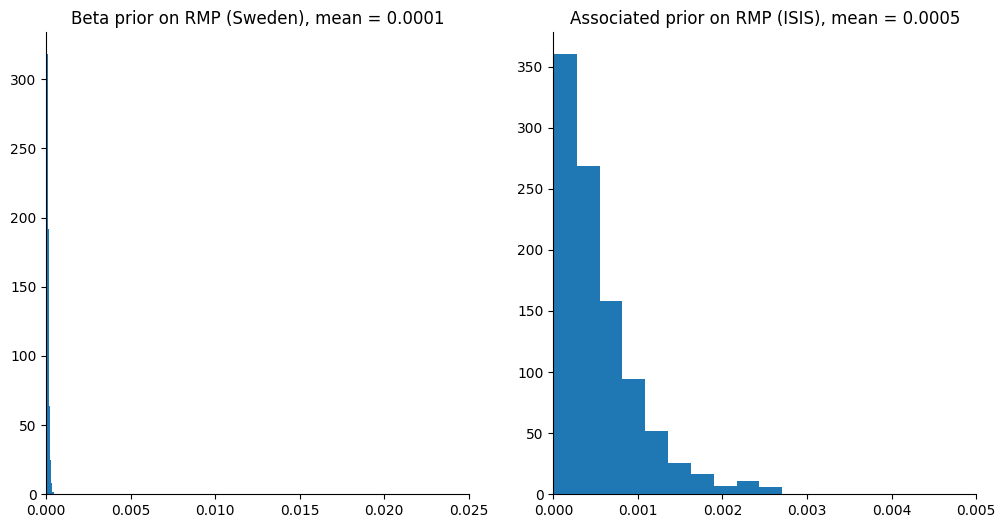

In [18]:
# for Sweden, the observed cases dicate the Beta distribution parameters,
#  2 out of 20000 observations

with pyro.plate("samples", 1000):
    probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))


# for isis, suppose for now we guess uniformly the RMP is between 1 and 10 times higher

with pyro.plate("multipliers", 1000):
    multiplier = pyro.sample("probs_isis", dist.Uniform(1, 10))
    probs_isis = (probs_sweden * multiplier).clamp(0, 1)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(probs_sweden)
ax[0].set_title(f"Beta prior on RMP (Sweden), mean = {probs_sweden.mean():.4f}")
ax[0].set_xlim(0, 0.025)


ax[1].hist(probs_isis)
ax[1].set_title(f"Associated prior on RMP (ISIS), mean = {probs_isis.mean():.4f}")
ax[1].set_xlim(0, 0.005)


sns.despine()
fig.show()

## Getting posteriors by composing Bayesian priors with the precise model


Now we put the priors together with the precise core. We sample from priors, pass to the precise model, collect the propagated posteriors.

In [19]:
bayesian_samples = 2000


def bayesian_missing_fingers():
    outcomes = []

    with pyro.plate("bayesia_samples", bayesian_samples):
        probs_sweden = pyro.sample("probs_sweden", dist.Beta(2, 19998))
        multiplier = pyro.sample("probs_isis", dist.Uniform(1, 100))
        probs_isis = (probs_sweden * multiplier).clamp(0, 1)

        outcomes = swedish_fingers_guilt_precise_core(
            rmp_fingers_sweden=probs_sweden,
            pr_fingers_match_if_isis=probs_isis,
            num_particles=3e5,
        )

        return outcomes


outcomes = bayesian_missing_fingers()

/tmp/ipykernel_54286/3127511403.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


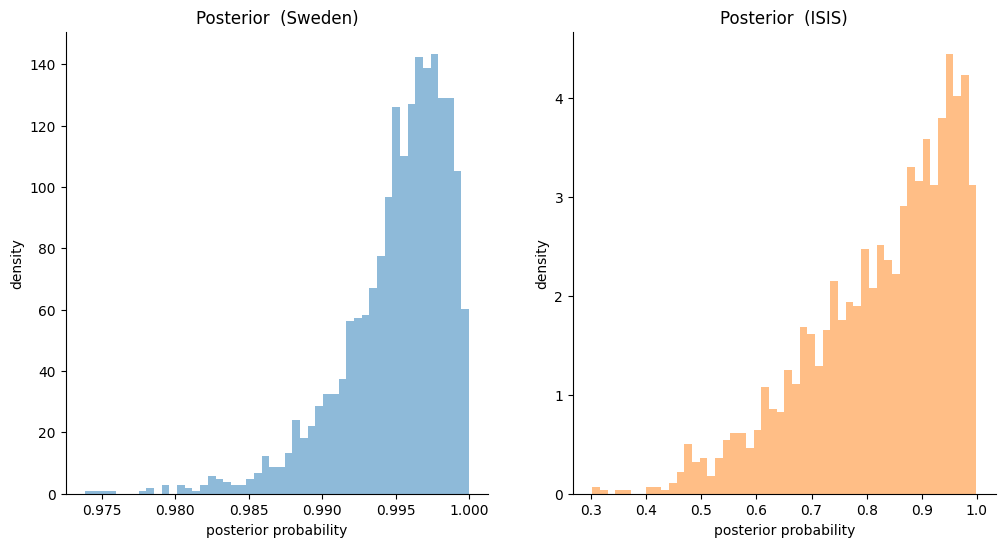

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
posterior_sweden = outcomes["posterior_guilty_fingers_sweden"]
posterior_isis = outcomes["posterior_guilty_fingers_isis"]

cmap = colormaps[40]
#Norm = plt.Normalize(vmin=0.9, vmax=1)
c1 = ax[0].hist(
    posterior_sweden.numpy(), bins=50, density=True, color="C0", alpha=0.5
)
c2 = ax[1].hist(
    posterior_isis.numpy(), bins=50, density=True, color="C1", alpha=0.5
)
ax[0].set_title("Posterior  (Sweden)")
ax[1].set_title("Posterior  (ISIS)")
ax[0].set_xlabel("posterior probability")
ax[1].set_xlabel("posterior probability")
ax[0].set_ylabel("density")
ax[1].set_ylabel("density")
sns.despine()
fig.show()


## Compute weights using the posteriors

In [26]:
print(range(bayesian_samples))
sweden_posteriors_yes = outcomes["posterior_guilty_fingers_sweden"]
sweden_posteriors_no = 1 - outcomes["posterior_guilty_fingers_sweden"]
sweden_distros = torch.stack(
    [sweden_posteriors_no, sweden_posteriors_yes], dim=1
)
assert sweden_distros.shape == (bayesian_samples, 2)
assert torch.allclose(sweden_distros.sum(dim = -1), torch.tensor(1.))

sweden_weights = pot.weight(sweden_distros)

outcomes["sweden_weights"] = sweden_weights


range(0, 2000)


In [28]:

isis_posteriors_yes = outcomes["posterior_guilty_fingers_isis"]
isis_posteriors_no = 1 - outcomes["posterior_guilty_fingers_isis"]
isis_distros = torch.stack([isis_posteriors_no, isis_posteriors_yes], dim=1)
assert isis_distros.shape == (bayesian_samples, 2)
assert torch.allclose(isis_distros.sum(dim = -1), torch.tensor(1.))
isis_weights = pot.weight(isis_distros)

outcomes["isis_weights"] = isis_weights

/tmp/ipykernel_54286/41362069.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


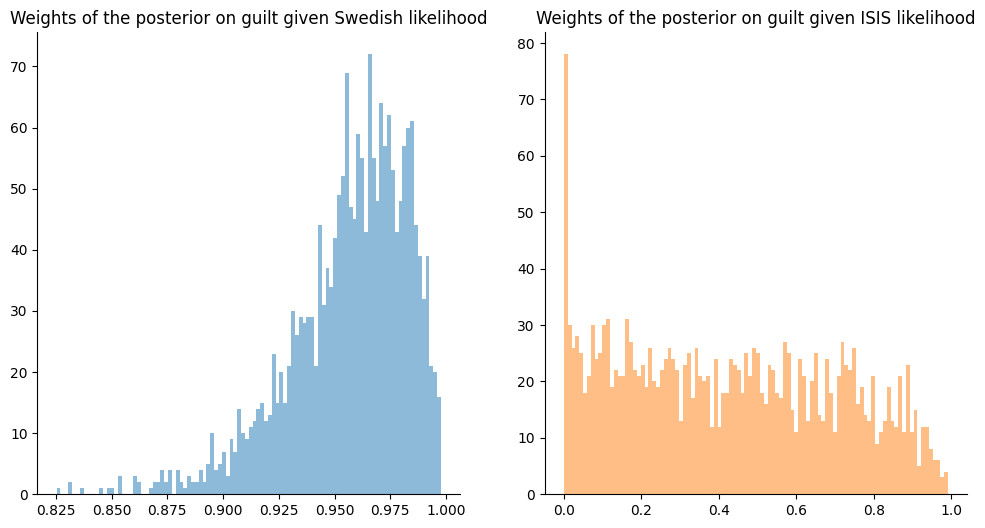

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))


cmap = colormaps[40]

ax[0].hist(outcomes["sweden_weights"], bins=100, color="C0", alpha=0.5)
ax[0].set_title(f"Weights of the posterior on guilt given Swedish likelihood")
ax[1].hist(outcomes["isis_weights"], bins=100, color="C1", alpha=0.5)
ax[1].set_title(f"Weights of the posterior on guilt given ISIS likelihood")
sns.despine()
fig.show()